In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:

df = pd.read_csv("netflix.csv")
closed_prices = df["Close"]

seq_len = 15

mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

In [3]:

X = []
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

X = np.array(X)[... , None]
y = np.array(y)[... , None]
    
train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()

In [4]:
class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm(x)
        return self.fc(hidden[-1 , :])
model = Model(1 , 64)

optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
loss_fn = nn.MSELoss()

num_epochs = 100

In [5]:
for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output , train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 and epoch != 0:
        print(epoch , "epoch loss" , loss.detach().numpy())

model.eval()
with torch.no_grad():
    output = model(test_x)

10 epoch loss 0.004227154
20 epoch loss 0.0030172027
30 epoch loss 0.00042631582
40 epoch loss 0.000109510045
50 epoch loss 0.00011815447
60 epoch loss 3.150611e-05
70 epoch loss 1.9648553e-05
80 epoch loss 2.2451164e-05
90 epoch loss 2.0422876e-05


Green = Real
Red = Predicted


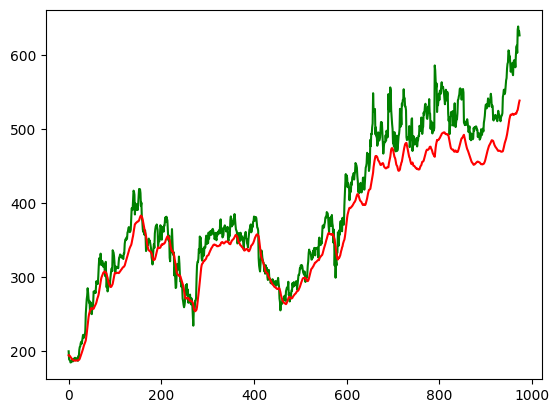

In [6]:
pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())
print('Green = Real')
print('Red = Predicted')
plt.plot(real.squeeze() , color = "green" , label = "real")
plt.plot(pred.squeeze() , color = "red" , label = "predicted")
plt.show()